# ProWave - WaveNet-based Protein Generation

Authors: Hans Jakob Damsgaard & Lucas Balling

02456 Deep Learning project: ProGen

## Initialization

Run the commmand below if you have not yet installed the [TAPE project](https://github.com/songlab-cal/tape).

In [ ]:
#!pip install tape_proteins

#### Importing needed packages

In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import tape

#### Importing the data

We were unable to make the data download script, `download_data.sh`, run from Jupyter, so instead we ran it manually and simply placed the resulting files in the right folder for TAPE to find them. We import all the data in the LMDB format as it is most easily worked with in Python.

In [2]:
from tape.datasets import LanguageModelingDataset

data_path = '/Users/lucasballing/Desktop/DeepLearningProject/prowave-main/data/'
#data_path = 'E:/Pfam/data/'
#train_data   = LanguageModelingDataset(data_path, 'train')
#valid_data   = LanguageModelingDataset(data_path, 'valid')
#holdout_data = LanguageModelingDataset(data_path, 'holdout')

#### Understanding data features

To get a good understanding of the data provided in the imported dataset, we provide plots of certain features and their ranges. Data is already split into the three required subsets; train, validation, and holdout by TAPE, so it is also interesting to understand this split.

In [3]:
# Split sizes
print(f'Training data has shape ({len(train_data)}, {len(train_data[0])})')
print(f'Validation data has shape ({len(valid_data)}, {len(valid_data[0])})')
print(f'Holdout data has shape ({len(holdout_data)}, {len(holdout_data[0])})')

# Original data columns
from tape.datasets import LMDBDataset
lmdb_train = LMDBDataset(data_path+'pfam/pfam_train.lmdb')
print(f'File data entries look like this: {lmdb_train[0]}')
del lmdb_train

# Data columns - all subsets are taken from the same overall dataset, so the columns are the same
# From combining information from LMDBDataset and LanguageModelingDataset, we know the columns are
# - IUPAC-encoded protein string
# - Input mask (for masked-token prediction)
# - Protein clan
# - Protein family
# The protein ID (i.e., its number within its clan and family) is not included
print(f'Encoded data entries look like this: {train_data[0]}')

NameError: name 'train_data' is not defined

In [ ]:
#from utils import setify

# Fetch results from all splits
#results = setify([train_data, valid_data, holdout_data])

# Clans in splits
#clans = results[0][0]
#print(f'Unique clans in training data {len(clans[0])}')
#print(f'Unique clans in validation data {len(clans[1])}')
#print(f'Unique clans in holdout data {len(clans[2])}')

# Families in splits
#families = results[0][1]
#print(f'Unique families in training data {len(families[0])}')
#print(f'Unique families in validation data {len(families[1])}')
#print(f'Unique families in holdout data {len(families[2])}')

# PRINTS:
# Unique clans in training data 623
# Unique clans in validation data 623
# Unique clans in holdout data 8
# Unique families in training data 17737
# Unique families in validation data 15974
# Unique families in holdout data 28


#### Creating some histograms
In this section, we plot some histograms of the datasets to visulise the distribution of clan and family IDs. 

In [ ]:
# Histograms of protein counts in clans
# TRAINING
df = pd.DataFrame(results[1][0], columns=['Clan', 'Count'])
sns.displot(df, x='Clan')
plt.title('Training - Protein count vs Clan')
plt.show()

# VALIDATION
df = pd.DataFrame(results[1][1], columns=['Clan', 'Count'])
sns.displot(df, x='Clan')
plt.title('Validation - Protein count vs Clan')
plt.show()

# HOLDOUT
df = pd.DataFrame(results[1][2], columns=['Clan', 'Count'])
sns.displot(df, x='Clan')
plt.title('Holdout - Protein count vs Clan')
plt.show()

# Histograms of protein counts in families
# TRAINING
df = pd.DataFrame(results[2][0], columns=['Family', 'Count'])
sns.displot(df, x='Family')
plt.title('Training - Protein count vs Clan')
plt.show()

# VALIDATION
df = pd.DataFrame(results[2][1], columns=['Family', 'Count'])
sns.displot(df, x='Family')
plt.title('Validation - Protein count vs Clan')
plt.show()

# HOLDOUT
df = pd.DataFrame(results[2][2], columns=['Family', 'Count'])
sns.displot(df, x='Family')
plt.title('Holdout - Protein count vs Clan')
plt.show()


# Idea and Initial Implementation
We intend to follow the ideas presented in the ProGen paper relatively closely. That is, our network will be trained on conditioned aminoacid sequences with the only two available conditioning tags being the clan and family IDs. To enable this, our network's input will be as shown on the figure below.

<img src="../Training.png" width="500"/>

So, like ProGen, our input $x=[c;a]$ is a sequence of encoded conditioning tags $c=(c_0,...,c_n)$ (in this case just two), and a starting sequence $a=(a_0, ..., a_n)$ of aminoacids for starting the sequence generation. The sequence is fed one character at a time to the network, which accumulates state before starting generation. We intend to let the network run free either until it generates an end character or until the generated sequence has length 500.


## One-hot encoding
One way to represent a fixed amount of words is through one-hot encoding. We intend to use one-hot encoding for both aminoacids as well as conditioning tags meaning that the input characters to our network become rather large. This may seem inefficient due to the great sparsity in the vectors produced, but we intend to limit this sparsity by decreasing the number of clans and families considered. This will allow us to generate proteins only for a subset of the available clans and families but at a much shorter required training and evaluation time. 

An example of a one-hot encoding is shown below:

| Amionacid    | one-hot encoded vector   |
| ------------- |--------------------------|
| Ala = A        | $= [1, 0, 0, \ldots, 0]$ |
| Asx = B        | $= [0, 1, 0, \ldots, 0]$ |
| Cys = C    | $= [0, 0, 1, \ldots, 0]$ |
| ... | ... |
| pad   | $= [0, 0, 0, \ldots, 1]$ |

Although the implementation from earlier in the course, which is used below, works well, we have decided to instead use Pytorch's own Embedding module which allows us to skip manually encoding vectors.

In [ ]:
from utils import one_hot_encode, one_hot_encode_sequence

# Testing the implementation
vocab_size = 30
test_word = one_hot_encode(1, vocab_size)
print(f'Our one-hot encoding of \'1\' has shape {test_word.shape}.')
print(test_word)

test_sentence = one_hot_encode_sequence(holdout_data[1][0], vocab_size)
print(f'Our one-hot encoding of \'{holdout_data[1][0]}\' has shape {test_sentence.shape}.')
print(test_sentence)

## Reducing input size
To reduce training time and problem size, we intend to extract 10 clans and their families from the training set and use those for training the network. Data is stored in sorted order in the training data set meaning that we can simply store elements until we see the 11th clan ID at which we can stop looking through the dataset. This is preferable over having to look through the entire dataset (as we did to gather plot data earlier), as such an operation takes a long time due to the mere size of the dataset.

As part of this operation, we also throw away the input masks that are included in the original dataset and attempt to limit data size by using `int8` instead of the original `int64` format for encoded sequences.

In [8]:
# Reduce data size by picking only 10 first classes of the training data
#from utils import get_data
#dataset = get_data(train_data, 10)
with open(data_path+'train_red_reduced2.pkl', 'wb') as f:
    pkl.dump(dataset2, f)

NameError: name 'dataset' is not defined

In [3]:
# Load the reduced dataset
with open(data_path+'train_red.pkl', 'rb') as f:
    dataset = pkl.load(f)
print(dataset.head())

# Reduce the Dataset
dataset2 = dataset[dataset['Family ID'].isin(list(range(100)))]

# The Save the reduced Dataset
with open(data_path+'train_red_reduced2.pkl', 'wb') as f:
    pkl.dump(dataset2, f)

# The put dataset into dataset2
dataset = dataset2

                                            Sequence  Clan ID  Family ID
0  [2, 21, 23, 13, 14, 25, 21, 13, 15, 12, 5, 13,...        0       1464
1  [2, 15, 15, 25, 22, 11, 14, 20, 5, 15, 19, 14,...        0       2309
2  [2, 21, 8, 10, 23, 21, 21, 23, 21, 15, 25, 22,...        0        304
3  [2, 15, 11, 13, 25, 15, 8, 5, 10, 22, 11, 25, ...        3      10745
4  [2, 9, 12, 13, 11, 13, 5, 25, 22, 8, 15, 9, 5,...        9       8633


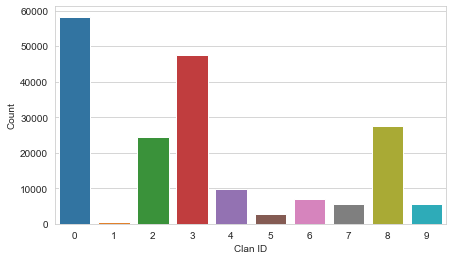

In [4]:
pdf = pd.DataFrame.from_dict({'Clan ID' : list(range(10)),'Count' : [len(dataset[dataset['Clan ID']==i]) for i in range(10)]})
plt.figure(figsize=(7,4))
sns.barplot(x='Clan ID', y='Count', data=pdf)
plt.show()

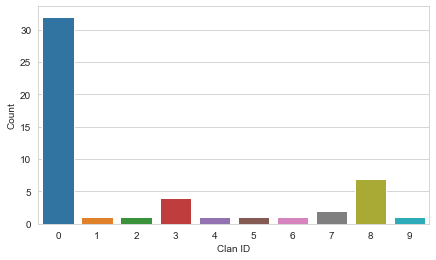

In [5]:
pdf = pd.DataFrame.from_dict({'Clan ID' : list(range(10)),'Count' : [len(set(dataset[dataset['Clan ID']==i]['Family ID'])) for i in range(10)]})
plt.figure(figsize=(7,4))
sns.barplot(x='Clan ID', y='Count', data=pdf)
plt.show()

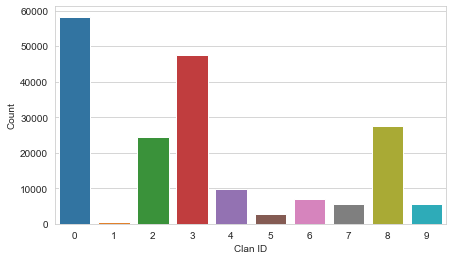

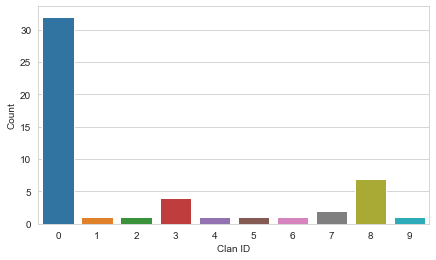

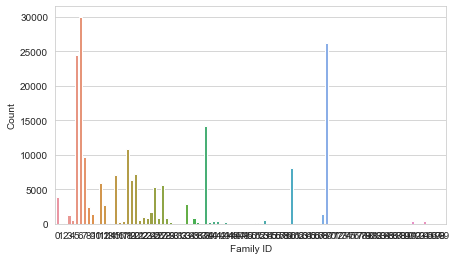

In [6]:
dataset2 = dataset[dataset['Family ID'].isin(list(range(100)))]
pdf = pd.DataFrame.from_dict({'Clan ID' : list(range(10)),'Count' : [len(dataset[dataset['Clan ID']==i]) for i in range(10)]})
plt.figure(figsize=(7,4))
sns.barplot(x='Clan ID', y='Count', data=pdf)
plt.show()
pdf = pd.DataFrame.from_dict({'Clan ID' : list(range(10)),'Count' : [len(set(dataset[dataset['Clan ID']==i]['Family ID'])) for i in range(10)]})
plt.figure(figsize=(7,4))
sns.barplot(x='Clan ID', y='Count', data=pdf)
plt.show()
# Histogram of Family IDs
pdf = pd.DataFrame.from_dict({'Family ID' : list(range(100)),'Count' : [len(dataset[dataset['Family ID']==i]) for i in range(100)]})
plt.figure(figsize=(7,4))
sns.barplot(x='Family ID', y='Count', data=pdf)
plt.show()
# Plot some of the AmoniAcids

In [7]:
# Print Some information about the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188963 entries, 5 to 10396718
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Sequence   188963 non-null  object
 1   Clan ID    188963 non-null  int64 
 2   Family ID  188963 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 5.8+ MB


In [8]:
# Printing some more information about the dataset
datasetTest2 = pd.DataFrame(dataset)
datasetTest2['Sequence'] = datasetTest2['Sequence'].astype(object)
print(datasetTest2.dtypes)
datasetTest2.head()

Sequence     object
Clan ID       int64
Family ID     int64
dtype: object


,Sequence,Clan ID,Family ID
5,"[2, 16, 12, 25, 20, 21, 28, 9, 25, 11, 16, 9, ...",8,20
14,"[2, 19, 19, 9, 5, 25, 22, 20, 15, 13, 25, 21, ...",7,25
148,"[2, 5, 15, 20, 23, 5, 8, 21, 8, 11, 25, 22, 7,...",0,0
177,"[2, 22, 15, 15, 5, 23, 8, 14, 28, 22, 25, 17, ...",0,0
185,"[2, 21, 8, 15, 9, 25, 26, 20, 21, 5, 16, 9, 20...",0,11


## Data Preparation
Getting the Data ready for utilisation

This covers changing the Clan IDs, Family IDs and amoniacid Sequeces into values from 0 to 140 to prepare for the embedding and one hot incoding.

This means that all families will have an offset of 11. 
This additionally implies that the Aminoacids will have a offset of 111.

Here the value zero will be used for padding purposes.

### Input

| Feature   | Interval of Values   |
| ------------- |--------------------------|
| Clan ID   (10)    | $= 1 \ldots 10 $ |
| Family ID (99)    | $= 11 \ldots 110 $ |
| Aminoacids (30) | $= 111 \ldots 140 $ |


### Output

| Feature   | Interval of Values   |
| ------------- |--------------------------|
| Aminoacids (30) | $= 1 \ldots 31 $ |

In [9]:
# Determine Unique families
offset_Clans = 1
offset_Family = 11
offset_Aminoacid = 111

dataset_Pre = pd.DataFrame(datasetTest2)
for i in range(0, len(dataset_Pre)):
    dataset_Pre.iloc[i,1] = dataset_Pre.iloc[i,1] + offset_Clans
    dataset_Pre.iloc[i,2] = dataset_Pre.iloc[i,2] + offset_Family

dataset_Pre.iloc[:,0] = (dataset_Pre.iloc[:,0] + offset_Aminoacid)   

# Make sure all the values are positive
dataset_Pre['Sequence'] = dataset_Pre['Sequence'].abs()

dataset_Pre.head()

,Sequence,Clan ID,Family ID
5,"[113, 127, 123, 120, 125, 124, 117, 120, 120, ...",9,31
14,"[113, 126, 126, 120, 116, 120, 123, 125, 126, ...",8,36
148,"[113, 116, 126, 125, 122, 116, 119, 124, 119, ...",1,11
177,"[113, 123, 126, 126, 116, 122, 119, 125, 117, ...",1,11
185,"[113, 124, 119, 126, 120, 120, 119, 125, 124, ...",1,22


In [10]:
# Import function
from utils import get_data_input

# First the definition of input and output - Here only 10 amino acids should go into the Neural Network for the generation of the protein
X = get_data_input(dataset_Pre,10)
X.head()

,Sequence,Clan ID,Family ID
0,"[113, 127, 123, 120, 125, 124, 117, 120, 120, ...",9,31
1,"[113, 126, 126, 120, 116, 120, 123, 125, 126, ...",8,36
2,"[113, 116, 126, 125, 122, 116, 119, 124, 119, ...",1,11
3,"[113, 123, 126, 126, 116, 122, 119, 125, 117, ...",1,11
4,"[113, 124, 119, 126, 120, 120, 119, 125, 124, ...",1,22


In [11]:
# Create Output data
from utils import get_data_output

Y = get_data_output(dataset_Pre)
Y.head()

,Sequence
0,"[3, 17, 13, 10, 15, 14, 7, 10, 10, 12, 17, 10,..."
1,"[3, 16, 16, 10, 6, 10, 13, 15, 16, 14, 10, 14,..."
2,"[3, 6, 16, 15, 12, 6, 9, 14, 9, 12, 10, 13, 8,..."
3,"[3, 13, 16, 16, 6, 12, 9, 15, 7, 13, 10, 18, 1..."
4,"[3, 14, 9, 16, 10, 10, 9, 15, 14, 6, 17, 10, 1..."


### Pad all the Inputs and Outputs
Creating Input data and target values with padding - inspired from https://towardsdatascience.com/taming-lstms-variable-sized-mini-batches-and-why-pytorch-is-good-for-your-health-61d35642972e

This will make all input and output the same size.

Currently, there is an Input X and an output Y, which needs some padding before they can be used for training of the LSTM and the GRU



In [ ]:
# Pad the Input for the Neural Network to be the same size

## RNN Network for Protein Generation
This section will define the network architecture for the neural network RNN used as the backbone of the ProWave neural network for protein generation. Note that this network serves as a baseline implementation meant to test our ideas, while the final network we desire to implement, is a WaveNet-based model, which differs significantly from the network below.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

clanidsize = 623
familyids = 15000

class MyRecurrentNet(nn.Module):
    def __init__(self):
        super(MyRecurrentNet, self).__init__()
        
        # Recurrent layer
        self.lstm = nn.LSTM(input_size=(vocab_size),
                         hidden_size=1000,
                         num_layers=1,
                         bidirectional=False)
        
        # Output layer
        self.l_out = nn.Linear(in_features=1000,
                            out_features=vocab_size,
                            bias=False)
        
    def forward(self, x):
        # RNN returns output and last hidden state
        
        x, (h, c) = self.lstm(x)
        
        # Flatten output for feed-forward layer
        x = x.view(-1, self.lstm.hidden_size)
        
        # Output layer
        x = self.l_out(x)
        
        return x

net = MyRecurrentNet()
print(net)

### Training loop

It's time for us to train our network. In the section below, you will get to put your deep learning skills to use and create your own training loop. You may want to consult previous exercises if you cannot recall how to define the training loop.

In [ ]:
# Hyper-parameters
num_epochs = 200

# Initialize a new network
net = MyRecurrentNet()

import torch.optim as optim

# Define a loss function and optimizer for this problem
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.004, momentum=0.6) 

# Track loss
training_loss, validation_loss = [], []

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    net.eval()
        
    # For each sentence in validation set
    for inputs, targets in validation_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_idx = [word_to_idx[word] for word in targets]
        
        # Convert input to tensor
        inputs_one_hot = torch.Tensor(inputs_one_hot)
        inputs_one_hot = inputs_one_hot.permute(0, 2, 1)
        
        # Convert target to tensor
        targets_idx = torch.LongTensor(targets_idx)
        
        # Forward pass
        # zero the parameter gradients
        optimizer.zero_grad()
        output= net(inputs_one_hot)
        batch_loss = criterion(output, targets_idx)

        # forward + backward + optimize
        batch_loss.backward()
        optimizer.step() 
        
        # Compute loss
        # YOUR CODE HERE!
        loss = batch_loss
        
        # Update loss
        epoch_validation_loss += loss.detach().numpy()
    
    net.train()
    
    # For each sentence in training set
    for inputs, targets in training_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_idx = [word_to_idx[word] for word in targets]
        
        # Convert input to tensor
        inputs_one_hot = torch.Tensor(inputs_one_hot)
        inputs_one_hot = inputs_one_hot.permute(0, 2, 1)
        
        # Convert target to tensor
        targets_idx = torch.LongTensor(targets_idx)
        
        # Forward pass
        # zero the parameter gradients
        optimizer.zero_grad()
        output= net(inputs_one_hot)
        batch_loss = criterion(output, targets_idx)

        # forward + backward + optimize
        batch_loss.backward()
        optimizer.step() 
        
        # Compute loss
        # YOUR CODE HERE!
        loss = batch_loss
        
        # Update loss
        epoch_training_loss += loss.detach().numpy()
        
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    # Print loss every 10 epochs
    if i % 10 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')

        
# Get first sentence in test set
inputs, targets = test_set[1]

# One-hot encode input and target sequence
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_idx = [word_to_idx[word] for word in targets]

# Convert input to tensor
inputs_one_hot = torch.Tensor(inputs_one_hot)
inputs_one_hot = inputs_one_hot.permute(0, 2, 1)

# Convert target to tensor
targets_idx = torch.LongTensor(targets_idx)

# Forward pass
outputs = net.forward(inputs_one_hot).data.numpy()

print('\nInput sequence:')
print(inputs)

print('\nTarget sequence:')
print(targets)

print('\nPredicted sequence:')
print([idx_to_word[np.argmax(output)] for output in outputs])

# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()